# Sentiment Analysis on AirBnb reviews: Does review sentiment affect price?


In [9]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics


## Exploratory analysis on the details of AirBnb listings

In [10]:
listing_data = pd.read_csv('listings.csv')
listing_data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


 ## Data Preprocessing  (for listings)
 Looking at the dataframe presented above, we can tell that there are some columns which are not useful to our analysis, there are also some values which are NaN. We will be:
 1. Dropping columns that are irrelevant to our analysis
 2. Filling NaN values with 0
 3. Reformating numerical data if required
 4. Filter out irrelevant rows

In [11]:
# From this, we can see that there are 92 columns of data in this dataset,
#we will need get a sense of what each column is in order to filter our dataset
listing_data.shape

(3818, 92)

In [12]:
# We will mainly be using categorical, numerical and text data
listing_data = listing_data[['id','name','summary','review_scores_rating','property_type','room_type','reviews_per_month','number_of_reviews','price']]
listing_data.head()

,id,name,summary,review_scores_rating,property_type,room_type,reviews_per_month,number_of_reviews,price
0,241032,Stylish Queen Anne Apartment,NaN,95.0,Apartment,Entire home/apt,4.07,207,$85.00
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,96.0,Apartment,Entire home/apt,1.48,43,$150.00
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,97.0,House,Entire home/apt,1.15,20,$975.00
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,Apartment,Entire home/apt,NaN,0,$100.00
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,92.0,House,Entire home/apt,0.89,38,$450.00


In [13]:
# replacing NaN values with 0
listing_data.fillna(0, inplace=True)

#Extract the price column
price = listing_data["price"]
#Create an empty list to append the cleaned data to
prices = []
#clean the price data to make it a float
for p in price:
    # Removes the $ sign. Change the "," in the thousands
    p=float(p[1:].replace(',',''))
    # Add the clean data to the new list
    prices.append(p)
    
#Replace the old price with the cleaned data
listing_data["price"] = prices


In [14]:
#From here we can see that some of the numerical values are 0 (bathrooms,beds etc). 
#Since we will expect that an otherwise normal Airbnb to have these amenities, we will drop the rows where these values are 0.
listing_data.describe()

,id,review_scores_rating,reviews_per_month,number_of_reviews,price
count,3.818000e+03,3818.000000,3818.000000,3818.000000,3818.000000
mean,5.550111e+06,78.518596,1.737514,22.223415,127.976166
std,2.962660e+06,35.979061,1.835425,37.730892,90.250022
min,3.335000e+03,0.000000,0.000000,0.000000,20.000000
25%,3.258256e+06,87.000000,0.310000,2.000000,75.000000
50%,6.118244e+06,95.000000,1.105000,9.000000,100.000000
75%,8.035127e+06,98.000000,2.660000,26.000000,150.000000
max,1.034016e+07,100.000000,12.150000,474.000000,1000.000000


In [15]:
# Removing listings that have 0 values
listing_data = listing_data[listing_data.review_scores_rating >0]
listing_data = listing_data[listing_data.reviews_per_month >0]
listing_data = listing_data[listing_data.number_of_reviews >0]
listing_data.head()

,id,name,summary,review_scores_rating,property_type,room_type,reviews_per_month,number_of_reviews,price
0,241032,Stylish Queen Anne Apartment,0,95.0,Apartment,Entire home/apt,4.07,207,85.0
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,96.0,Apartment,Entire home/apt,1.48,43,150.0
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,97.0,House,Entire home/apt,1.15,20,975.0
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,92.0,House,Entire home/apt,0.89,38,450.0
5,5956968,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,95.0,House,Private room,2.45,17,120.0


## Exploratory Analysis (reviews)
For a review on a listing, we have identified that the two things that will affect the accuracy of a listing is the number of reviews on a listing, as well as the length of the review. We will be exploring the distribution of reviews based on these two factors

In [17]:
reviews_data = pd.read_csv('reviews.csv')
reviews_data.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [18]:
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


208356     474
365550     466
25002      404
47196      353
63308      320
          ... 
4825073      1
6392029      1
716829       1
8327083      1
8350401      1
Name: listing_id, Length: 3191, dtype: int64


/Users/loissen/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='listing_id', ylabel='Density'>

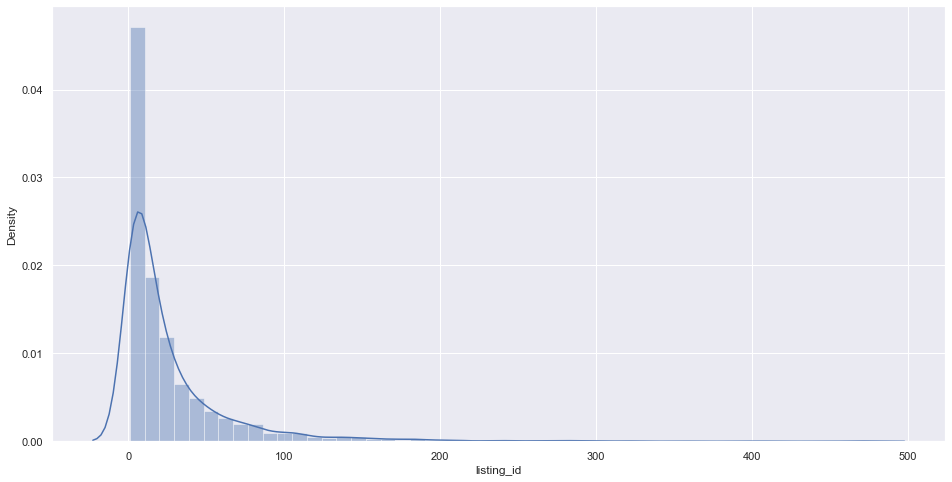

In [19]:
# Counting how many reviews are there per listing
f = plt.figure(figsize=(16, 8))
print(reviews_data["listing_id"].value_counts())
sb.distplot(reviews_data["listing_id"].value_counts())

From this table, we can tell that there are 474 listings with reviews, and the number of reviews ranges from 1 to 474. Since we are studying the relationship between reviews and the listing, listings with too little reviews will be removed.

In [20]:
# Counting the maximum amount of words in a review
max_len = reviews_data['comments'].str.split().str.len().max()
print('Maximum number of words in a review: ', max_len)

Maximum number of words in a review:  649.0


In [21]:
# Viewing the longest review
reviews_data[reviews_data['comments'].str.split().str.len() == 649]

,listing_id,id,date,reviewer_id,reviewer_name,comments
5816,107962,1168194,2012-04-23,1869876,Houston,CURLERS - this is the perfect location when yo...


In [22]:
#Viewing the longest review
reviews_data.iloc[5816,5]

"CURLERS - this is the perfect location when you are competing at the Granite Curling Club (GCC.)  The Heller Lake Log Cabin was not only in a better location than the local hotels but was cheaper and much nicer than the places our friends stayed this weekend.  And for larger groups there is also a house for rental on the same property.  \r\n\r\nWe flew into town for a Bonspiel (curling tournament) at the Granite Curling Club and this was the perfect location.  The club had a deal with some of the local hotels but when I looked into it they were 1) much farther away and 2) more expensive.  We were able to walk to GCC, which was only about three blocks away, while everyone else had to drive back and forth between the club and their hotel.  \r\n\r\nThe cabin is so nice and in such a great location for us that it makes the decision to return for future Bonspiels an easy one.  With there also being a house for rent on the same property we will likely have our whole team stay with us next t

/Users/loissen/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

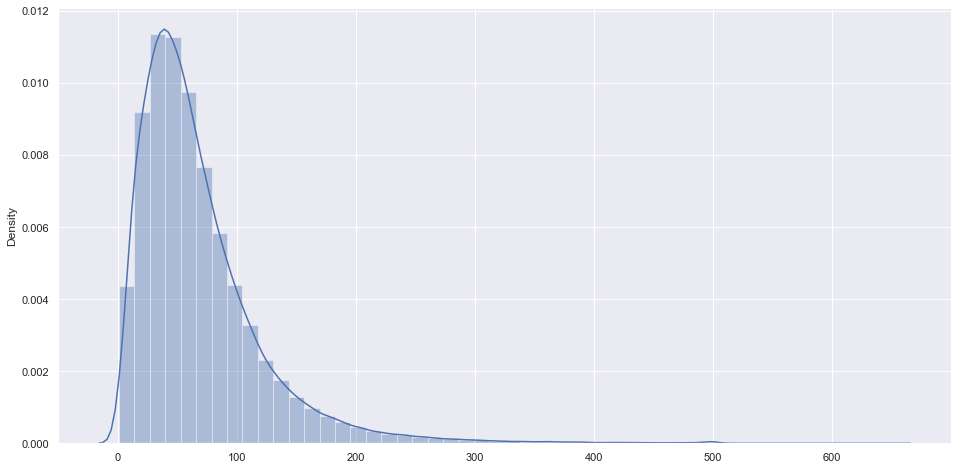

In [23]:
f = plt.figure(figsize=(16, 8))
sb.distplot(pd.DataFrame(reviews_data['comments'].str.split().str.len()))

From this plot, we can tell that most reviews ranges from 0-300 words. Reviews that are excessively long are difficult to estimate the sentiment as there will be a lot of irrelevant information and noise.

## Data Preprocessing (for reviews)
Before analysing the data, we will need to clean the data set in the following steps:

1. Remove listings that have too little reviews
2. Remove reviews that have too many words

In [24]:
reviews_data = reviews_data.dropna()
reviews_data.info

<bound method DataFrame.info of        listing_id        id        date  reviewer_id reviewer_name  \
0         7202016  38917982  2015-07-19     28943674        Bianca   
1         7202016  39087409  2015-07-20     32440555         Frank   
2         7202016  39820030  2015-07-26     37722850           Ian   
3         7202016  40813543  2015-08-02     33671805        George   
4         7202016  41986501  2015-08-10     34959538          Ming   
...           ...       ...         ...          ...           ...   
84844     3624990  50436321  2015-10-12     37419458          Ryan   
84845     3624990  51024875  2015-10-17      6933252         Linda   
84846     3624990  51511988  2015-10-20     19543701         Jaime   
84847     3624990  52814482  2015-11-02     24445024        Jørgen   
84848     9727246  56429621  2015-12-13     30860360     Stephanie   

                                                comments  
0      Cute and cozy place. Perfect location to every...  
1      Ke

In [25]:
# Dropping comments which are more than 300 words
reviews_data = reviews_data[reviews_data['comments'].str.split().str.len() < 300]
reviews_data = reviews_data.dropna()
# Dropping listings that have less than 10 reviews
reviews_data = reviews_data[reviews_data.groupby('listing_id').listing_id.transform('count') > 10]
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78253 entries, 0 to 84847
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     78253 non-null  int64 
 1   id             78253 non-null  int64 
 2   date           78253 non-null  object
 3   reviewer_id    78253 non-null  int64 
 4   reviewer_name  78253 non-null  object
 5   comments       78253 non-null  object
dtypes: int64(3), object(3)
memory usage: 4.2+ MB


# Sentiment Analysis on reviews using nltk
In this dataset, there are no numerical values to quantify how "good" or "bad" a review is. By performing sentiment analysis we will be able to see how positive or negative reviews affect prices

## Applying nltk's Sentiment Intensity Analyzer model

In [16]:
# Import nltk libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [26]:

# Sentimer Analyzer uses the vader lexicon package
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/loissen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:
# Create Analyzer object
sia = SentimentIntensityAnalyzer()
# Create empty rows in dataframe and set it to 0 first.
reviews_data['negative_score']=0.0
reviews_data['positive_score']=0.0
reviews_data['neutral_score']=0.0
reviews_data['compound_score']=0.0
# Define the function for sentiment analysis
def sentiment_analysis(index):
  # Equates the score given by the sentiment analysers
  reviews_data.at[index,'negative_score'] = sentiment['neg']
  reviews_data.at[index,'positive_score'] = sentiment['pos']
  reviews_data.at[index,'neutral_score']= sentiment['neu']
  reviews_data.at[index,'compound_score'] = sentiment['compound']

# Iterating through each review
for index,row in reviews_data.iterrows():
    # Assign the sentiment score array to a variable sentiment
    sentiment = sia.polarity_scores(row['comments'])
    # Calls the function defined above with the parameters
    sentiment_analysis(index)

reviews_data.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,negative_score,positive_score,neutral_score,compound_score
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.000,0.538,0.462,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.000,0.391,0.609,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.043,0.185,0.772,0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.035,0.200,0.765,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.000,0.345,0.655,0.9783


/Users/loissen/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/loissen/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/loissen/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

Text(0.5, 1.0, 'Distribution of Compound scores')

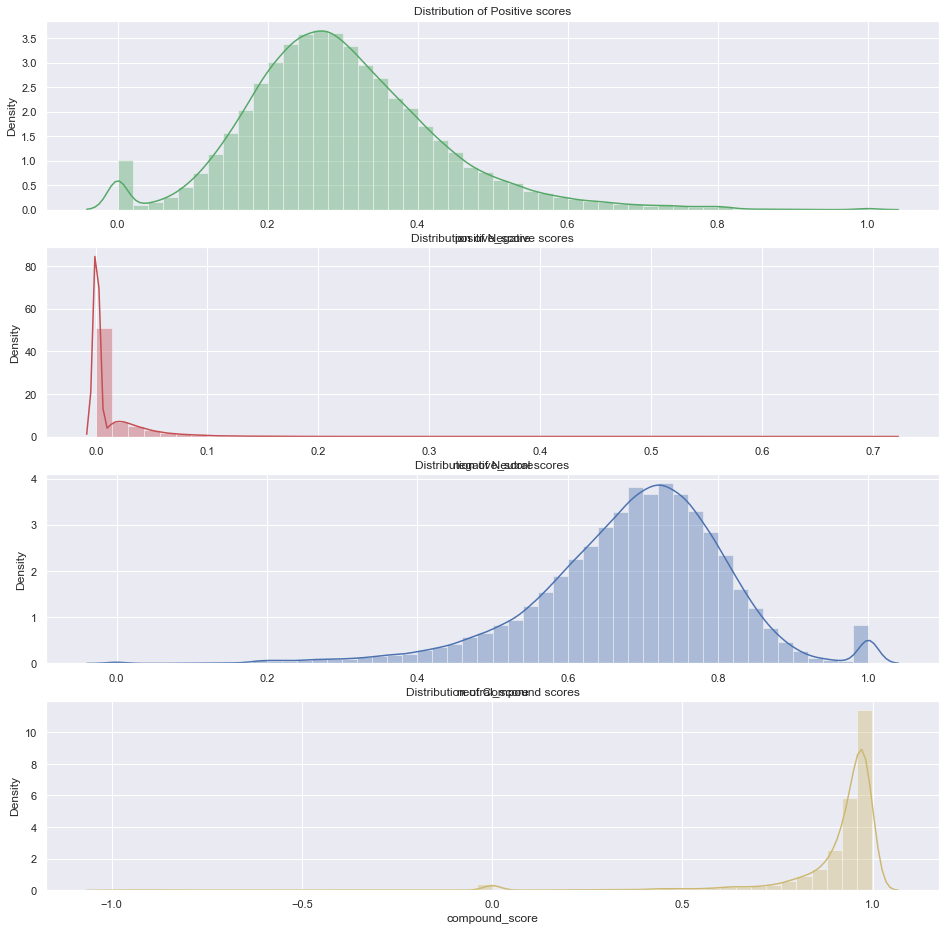

In [28]:
# Visualising the positive, negative, neutral and compound scores
f, axes = plt.subplots(4, 1, figsize=(16, 16))
sb.distplot(reviews_data["positive_score"],ax = axes[0], color = 'g').set_title("Distribution of Positive scores")
sb.distplot(reviews_data["negative_score"],ax = axes[1],color = 'r').set_title("Distribution of Negative scores")
sb.distplot(reviews_data["neutral_score"],ax = axes[2],color = 'b').set_title("Distribution of Neutral scores")
sb.distplot(reviews_data["compound_score"],ax = axes[3],color = 'y').set_title("Distribution of Compound scores")

From these plots, one thing that is very apparent is that there is very little comments with negative sentiments and a relatively evenly distributed score for neutral and positive sentiments. As a result, this causes the compound score to be largely skewed to the right. From this we can likely say that people most oftenly only leave comments which are positive in nature

## Visualising common words using a wordcloud

In [29]:
# Importing libraries for wordcloud
from wordcloud import WordCloud, STOPWORDS
# Setting default stop words
stopwords = set(STOPWORDS)

words = ''.join(comments for comments in reviews_data['comments'])
#Creating a wordcloud
wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(words)

(-0.5, 399.5, 199.5, -0.5)

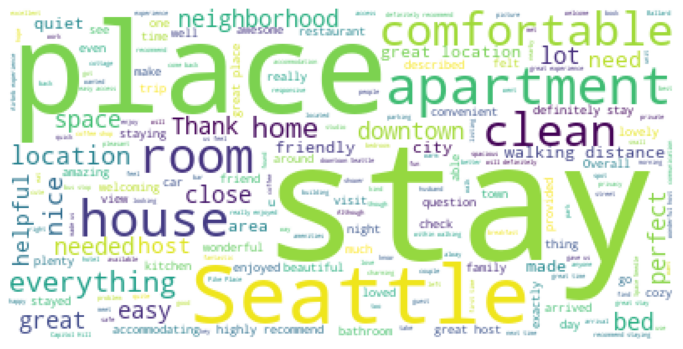

In [30]:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")

This word cloud visualises the common words used in a comment of an AirBnb apartment. The most popular words include "stay", "place","Seattle". Which doesn't tell us much. However we also have some positive descriptive words such as "nice","lovely","comfortable","clean" which are rather common as well

## How does reviews affect pricing?
Now that we have gotten the compound score, we can plot the compound score against the price to study their relationship. We can also use the review_score_rating column in listing.csv to further understand the relationship between reviews and pricing

In [31]:
review_score = reviews_data[['listing_id','compound_score']]
review_score.head()

,listing_id,compound_score
0,7202016,0.7901
1,7202016,0.9872
2,7202016,0.8718
3,7202016,0.8313
4,7202016,0.9783


In [32]:
# Calculates the mean compound_score of each listing_id 
review_score_mean = review_score.groupby(['listing_id']).mean()
review_score_mean.head()

,compound_score
listing_id,
4291,0.778260
5682,0.887364
6606,0.913877
7369,0.904060
9419,0.900456


In [33]:
# Obtain price, review_scores_rating and id from listings_data
listing_scores = listing_data[['id','review_scores_rating','price']]
listing_scores = listing_scores.set_index('id')
listing_scores.head()

,review_scores_rating,price
id,,
241032,95.0,85.0
953595,96.0,150.0
3308979,97.0,975.0
278830,92.0,450.0
5956968,95.0,120.0


In [34]:
#Append the two data frames together based on their id (set as index)
merged_score = review_score_mean.merge(listing_scores, left_index=True, right_index=True)
merged_score["compound_score"] = merged_score["compound_score"] * 100
merged_score = merged_score.dropna()
merged_score.head()

,compound_score,review_scores_rating,price
4291,77.826000,92.0,82.0
5682,88.736419,96.0,48.0
6606,91.387692,93.0,90.0
7369,90.406000,94.0,85.0
9419,90.045584,91.0,90.0


/Users/loissen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/loissen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='compound_score', ylabel='price'>

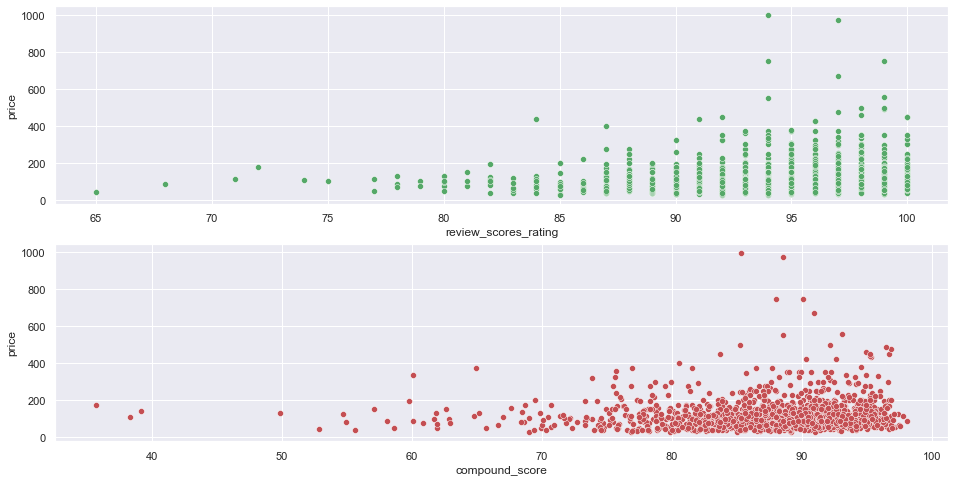

In [35]:
# Visualising review scores and price
f, axes = plt.subplots(2, 1, figsize=(16, 8))
sb.scatterplot("review_scores_rating","price",ax = axes[0], data = merged_score,color = 'g')
sb.scatterplot("compound_score","price",ax = axes[1], data = merged_score,color = 'r')

## Identifying anomalies using Nearest Neighbors
We will be attempting to fit a linear regression model to visualise if there is any positive relationship between compound_score and price. But before so, its quite clear that some of these data points are anomalies, we will be using nearest neighbors to filter them out

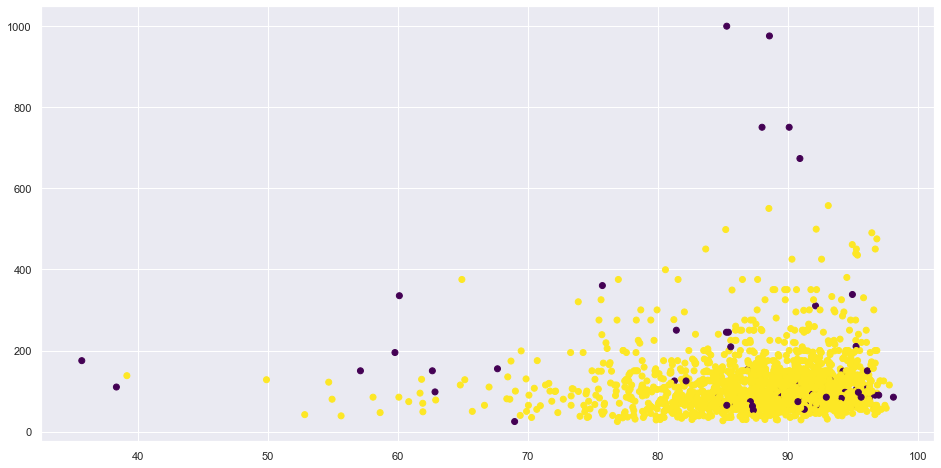

In [36]:
# Import LocalOutlierFactor from sklearn.neighbors
from sklearn.neighbors import LocalOutlierFactor

# Extract the Features from the Data
X = pd.DataFrame(merged_score[["compound_score", "price"]])

# Set the Parameters for Neighborhood
num_neighbors = 5      # Number of Neighbors
cont_fraction = 0.05    # Fraction of Anomalies with respect to the total data

# Create Anomaly Detection Model using LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors = num_neighbors, contamination = cont_fraction)

# Fit the Model on the Data and Predict Anomalies.
# Predict a label anomaly
lof.fit(X)
# Visualize the Anomalies in the Data
# Predict the Anomalies
# lof is local oultier factor
labels = lof.fit_predict(X)

# Append Labels to the Data
X_labeled_Anomaly = X.copy()
X_labeled_Anomaly["Anomaly"] = pd.Categorical(labels)
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "compound_score", y = "price",c ='Anomaly', cmap = 'viridis', data = X_labeled_Anomaly)

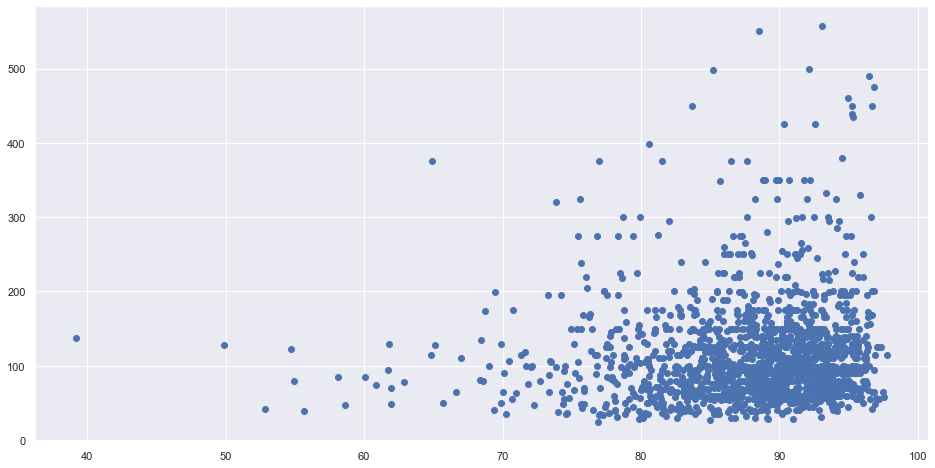

In [37]:
# Iterate through the rows and find which are the anomalies
for index,row in X_labeled_Anomaly.iterrows():
    # -1 are all the anomalies
    if row["Anomaly"] == -1:
        # Drop all the anomalies to "clean the data"
        X_labeled_Anomaly = X_labeled_Anomaly.drop(index)

# Plot the "Cleaned" data for visualization
f, axes = plt.subplots(1, 1, figsize=(16,8))        
plt.scatter(x = "compound_score", y = "price", cmap = 'viridis', data = X_labeled_Anomaly)

## Fitting a linear regression model for future predictions
Now that we have removed the anomalies, we will fit a linear regression model to visualise any relationship between compound score and price

Intercept of Regression 	: b =  46.48912008258165
Coefficients of Regression 	: a =  [0.76459279]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.005376512173768777
Mean Squared Error (MSE) 	: 4404.482787651404



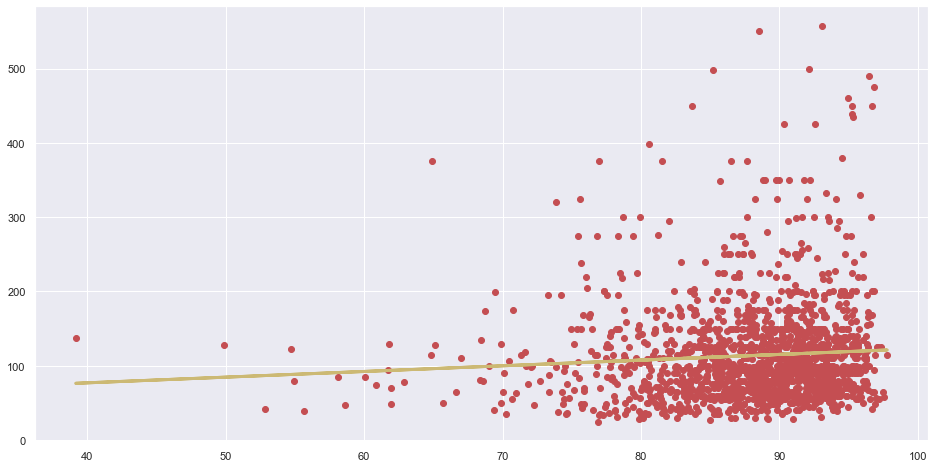

In [38]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

xdata = X_labeled_Anomaly[["compound_score"]]
ydata = X_labeled_Anomaly["price"]

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(xdata, ydata)        # train the linear regression model


# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()
# Predict Total values corresponding to HP
y_pred = linreg.predict(xdata)
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(xdata, ydata))
print("Mean Squared Error (MSE) \t:", mean_squared_error(ydata, y_pred))
print()
# Formula for the Regression line
regline_x = X_labeled_Anomaly["compound_score"]
regline_y = linreg.intercept_ + linreg.coef_ * xdata

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(xdata, ydata, color = 'r')
plt.plot(regline_x, regline_y, 'y-', linewidth = 3)
plt.show()


While at first glance, it seems that the higher the review score the higher the price. However, after fitting a linear regression model, we can see that this positive relationship is lesser than we would expect.

In conclusion, reviews only have a limited influence with pricing, although it is a positive one.